# Imports 

In [1]:
import glob
import os
import numpy as np
import PIL
from datasets import Image, Dataset
from datasets import load_dataset   
import pandas as pd
import os
import winsound
from transformers import SamProcessor
import chime
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.utils.data import Dataset
from transformers import SamProcessor
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from transformers import SamModel 
import json
import torch
import os
import shutil
import functions

c:\Users\bouhe\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'pydicom'

In [4]:
import sys
print(sys.version)

3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


# Checking Gpu

## Pytorch

In [2]:
import torch

In [3]:
print(torch.cuda.is_available())

True


The provided segmentation labels have values of:

    1 for NCR
    2 for ED
    3 for ET
    0 for everything else.


# TRANSFORMES

the attention mechanism was introduced to improve the performance of the encoder-decoder model for machine translation.  
The idea behind the attention mechanism was to **permit the decoder** to utilize the most relevant parts of the input sequence in a flexible manner, by a weighted combination of all the encoded input vectors, with the most relevant vectors being attributed the <mark>highest weights</mark>. 

In this project we are going to use transformers instead of fully convolutional networks or a mixture of the two architectures.

## Segment anything

In [ ]:
%ls

In [50]:
%pip install -q git+https://github.com/huggingface/transformers.git

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
%pip install -q datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
%pip install -q monai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Read the csv file
data = pd.read_csv(r'C:\Users\bouhe\OneDrive\Bureau\pfe\dataset\png_format\metadata.csv')
data

,image_name,patient_id,time_stamp,scan_type,split
0,Slice_dim0_118.png,0,0,seg,train
1,Slice_dim1_113.png,0,0,t1c,train
2,Slice_dim1_112.png,0,0,t1c,train
3,Slice_dim1_111.png,0,0,t1c,train
4,Slice_dim1_110.png,0,0,t1c,train
...,...,...,...,...,...
1677973,Slice_dim2_98.png,1790,0,t1c,test
1677974,Slice_dim2_97.png,1790,0,t1c,test
1677975,Slice_dim2_96.png,1790,0,t1c,test
1677976,Slice_dim0_103.png,1790,0,t1n,test


In [5]:
d_t_gt = data.loc[(data['split'] == 'train') & (data['scan_type'] == 'seg')]
d_t_gt.sample

<bound method NDFrame.sample of                  image_name  patient_id  time_stamp scan_type  split
0        Slice_dim0_118.png           0           0       seg  train
677       Slice_dim1_62.png           0           0       seg  train
678       Slice_dim1_87.png           0           0       seg  train
679       Slice_dim1_88.png           0           0       seg  train
680       Slice_dim1_89.png           0           0       seg  train
...                     ...         ...         ...       ...    ...
1477663   Slice_dim2_94.png        1666           0       seg  train
1477683  Slice_dim1_107.png        1666           0       seg  train
1477684  Slice_dim1_103.png        1666           0       seg  train
1477685   Slice_dim1_93.png        1666           0       seg  train
1477741  Slice_dim1_108.png        1666           0       seg  train

[257445 rows x 5 columns]>

In [6]:
d_t_gt = d_t_gt[d_t_gt['patient_id'] <= 1173]
d_t_gt.sample

<bound method NDFrame.sample of                  image_name  patient_id  time_stamp scan_type  split
0        Slice_dim0_118.png           0           0       seg  train
677       Slice_dim1_62.png           0           0       seg  train
678       Slice_dim1_87.png           0           0       seg  train
679       Slice_dim1_88.png           0           0       seg  train
680       Slice_dim1_89.png           0           0       seg  train
...                     ...         ...         ...       ...    ...
1090495  Slice_dim0_147.png        1173           0       seg  train
1090496  Slice_dim0_146.png        1173           0       seg  train
1090497  Slice_dim0_145.png        1173           0       seg  train
1090498  Slice_dim0_144.png        1173           0       seg  train
1090519  Slice_dim0_160.png        1173           0       seg  train

[180094 rows x 5 columns]>

In [7]:
d_t_im = data.loc[(data['split'] == 'train') & ((data['scan_type'] == 't1c') | ( data['scan_type'] == 't1n') | (data['scan_type'] == 't2f') | (data['scan_type'] == 't2w'))]
d_t_im = d_t_im[d_t_im['patient_id'] <= 1173]
d_t_im.sample

<bound method NDFrame.sample of                  image_name  patient_id  time_stamp scan_type  split
1        Slice_dim1_113.png           0           0       t1c  train
2        Slice_dim1_112.png           0           0       t1c  train
3        Slice_dim1_111.png           0           0       t1c  train
4        Slice_dim1_110.png           0           0       t1c  train
5        Slice_dim1_109.png           0           0       t1c  train
...                     ...         ...         ...       ...    ...
1091089  Slice_dim0_157.png        1173           0       t2f  train
1091090  Slice_dim0_160.png        1173           0       t2f  train
1091091  Slice_dim0_159.png        1173           0       t2f  train
1091092  Slice_dim0_158.png        1173           0       t2f  train
1091093  Slice_dim0_165.png        1173           0       t2f  train

[720375 rows x 5 columns]>

In [8]:
d_test_gt = d_t_gt[d_t_gt['patient_id'] > 1173]
d_test_gt.sample

<bound method NDFrame.sample of Empty DataFrame
Columns: [image_name, patient_id, time_stamp, scan_type, split]
Index: []>

In [9]:
d_test_im = data.loc[(data['split'] == 'train') & ((data['scan_type'] == 't1c') | ( data['scan_type'] == 't1n') | (data['scan_type'] == 't2f') | (data['scan_type'] == 't2w'))]
d_test_im = d_test_im[d_test_im['patient_id'] > 1173]
d_test_im.sample

<bound method NDFrame.sample of                  image_name  patient_id  time_stamp scan_type  split
1091094  Slice_dim0_164.png        1174           0       t1c  train
1091095  Slice_dim0_163.png        1174           0       t1c  train
1091096  Slice_dim0_162.png        1174           0       t1c  train
1091097  Slice_dim0_161.png        1174           0       t1c  train
1091098  Slice_dim0_157.png        1174           0       t1c  train
...                     ...         ...         ...       ...    ...
1477840   Slice_dim1_92.png        1666           0       t1n  train
1477841  Slice_dim2_105.png        1666           0       t1n  train
1477842   Slice_dim1_94.png        1666           0       t1n  train
1477843   Slice_dim1_95.png        1666           0       t1n  train
1477844   Slice_dim1_93.png        1666           0       t1n  train

[309400 rows x 5 columns]>

In [10]:
print('Training cases:',len(set(d_t_im['patient_id'])),'Testing cases:',len(set(d_test_im['patient_id'])))

Training cases: 758 Testing cases: 375


In [11]:
parent_dir = r"C:\Users\bouhe\OneDrive\Bureau\pfe\dataset\png_format"
images_train = []
for i in range(len(d_t_im)):
    temp = d_t_im.iloc[i]
    folder = '-'.join(["BraTS-GLI",str(temp['patient_id']).zfill(5), str(temp['time_stamp']).zfill(3)])
    res = os.path.join(*[parent_dir,temp['split'],folder,temp['scan_type'],temp['image_name']])
    images_train.append(res)
    
gt_train = images_train

In [12]:
tmp = []
for string in gt_train:
    tm = ' '.join(string.split('\\'))
    r = tm.replace("t1c","seg")
    r = r.replace("t1n","seg")
    r = r.replace("t2f","seg")
    r = r.replace("t2w","seg")
    f ='\\'.join(r.split(' '))
    tmp.append(f)
gt_train = tmp

In [13]:
parent_dir = r"C:\Users\bouhe\OneDrive\Bureau\pfe\dataset\png_format"
images_test = []
for i in range(len(d_test_im)):
    temp = d_test_im.iloc[i]
    folder = '-'.join(["BraTS-GLI",str(temp['patient_id']).zfill(5), str(temp['time_stamp']).zfill(3)])
    res = os.path.join(*[parent_dir,temp['split'],folder,temp['scan_type'],temp['image_name']])
    images_test.append(res)


In [14]:
len(images_test)

309400

In [15]:
Dir = 'C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\'
images_test.remove(Dir +'BraTS-GLI-01432-000\\t2w\\Slice_dim1_50.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1n\\Slice_dim1_50.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1c\\Slice_dim1_50.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t2w\\Slice_dim1_49.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1n\\Slice_dim1_49.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1c\\Slice_dim1_49.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t2w\\Slice_dim1_48.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1n\\Slice_dim1_48.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1c\\Slice_dim1_48.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t2w\\Slice_dim1_47.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1n\\Slice_dim1_47.png')
images_test.remove(Dir +'BraTS-GLI-01432-000\\t1c\\Slice_dim1_47.png')


In [16]:
tmp = []
for string in images_test:
    tm = ' '.join(string.split('\\'))
    r = tm.replace("t1c","seg")
    r = r.replace("t1n","seg")
    r = r.replace("t2f","seg")
    r = r.replace("t2w","seg")
    f ='\\'.join(r.split(' '))
    tmp.append(f)
gt_test = tmp

In [17]:
t1c,t1n,t2f,t2w = [], [], [], []
for image, mask in zip(images_test, gt_test):
    if 't1c' in image :
        t1c.append((image,mask))
    elif 't1n'in image :
        t1n.append((image,mask))
    elif 't2f'in image :
        t2f.append((image,mask))    
    elif 't2w'in image  :
        t2w.append((image,mask))

In [18]:
final_t = []
for path_seg in gt_train :
    tmp_list = path_seg.split('\\')
    tmp_list.pop(-2)
    final_t.append('C:\\'+os.path.join(*(tmp_list[1:8] + ['train_fused'] + tmp_list[9:])))

In [19]:
uni_g = []
for path_name in gt_train:
    new_path = path_name.split('\\')
    uni_g.append(('\\').join(new_path[0:8]+['train']+new_path[9::]))

In [ ]:
file_list = gt_train

file_exist = [os.path.exists(file) for file in file_list]

all_exist = all(file_exist)

if all_exist:
    print("All files exist.")
else:
    print("Some files do not exist.")

In [ ]:
missing_indices = [index for index, file in enumerate(file_list) if not os.path.exists(file)]

if len(missing_indices) == 0:
    print("All files exist.")
else:
    print("Missing files at indices:", missing_indices)

In [22]:
metadata = d_t_im.to_dict('list')

In [ ]:
# Read the csv file
data = pd.read_csv(r"C:\Users\bouhe\OneDrive\Documents\Python Scripts\work_internship mitacs_backup\project_TransUNet\test.csv")
data

In [16]:
all([os.path.exists(name) for name in images_test])

True

In [178]:
exists = []
problem = []
c = 0
for image in images_test :
    c+=1
    exists.append(os.path.exists(image))
    if os.path.exists(image) == False :
        problem.append((c,image))

In [179]:
len(problem)

0

## DATASET

In [20]:
import datasets
dataset_tmp = datasets.Dataset.from_dict({"image": images_train,"label":uni_g}).cast_column("image", Image())
dataset = dataset_tmp.cast_column("label", Image())

In [21]:
t1n_filtered = [
    (image_path, seg_path) for image_path, seg_path in t1n if 'dim0' not in image_path and 'dim1' not in image_path
]


In [22]:
import datasets
dataset_tmp = datasets.Dataset.from_dict({"image": [t1n_filtered[i][0] for i in range(len(t1n_filtered))],"label":[t1n_filtered[i][1] for i in range(len(t1n_filtered))]}).cast_column("image", Image())
dataset_test = dataset_tmp.cast_column("label", Image())

In [75]:
t1n_filtered[0]

('C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\BraTS-GLI-01174-000\\t1n\\Slice_dim2_100.png',
 'C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\BraTS-GLI-01174-000\\seg\\Slice_dim2_100.png')

## Preprocessing

### Padding

In [ ]:
from PIL import Image as I, ImageOps

# Define the target shape for padding
target_shape = (256, 256)  # Specify the desired shape (width, height)

# List of image paths

# Iterate through the image paths
for path in images_train:
    # Open the image
    image = I.open(path)

    # Pad the image with zeros to the target shape
    padded_image = ImageOps.expand(image, border=(0, 0, target_shape[0] - image.width, target_shape[1] - image.height), fill=0)

    # Save the padded image
    padded_image.save(path)


In [ ]:
# Define the target shape for padding
target_shape = (256, 256)  # Specify the desired shape (width, height)

# Iterate through the image paths
for path in set(image_paths):
    # Open the image
    image = I.open(path)

    # Pad the image with zeros to the target shape
    padded_image = ImageOps.expand(image, border=(0, 0, target_shape[0] - image.width, target_shape[1] - image.height), fill=0)

    # Save the padded image
    padded_image.save(path)
    print(path)


In [ ]:
chime.success()

In [ ]:
# Open the image
image = I.open(meta['image'][0])

# Define the target shape for padding
target_shape = (256, 256)  # Specify the desired shape (width, height)

# Pad the image with zeros to the target shape
padded_image = ImageOps.expand(image, border=(0, 0, target_shape[0] - image.width, target_shape[1] - image.height), fill=0)


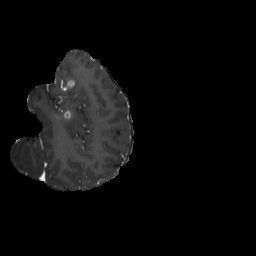

In [34]:
image = dataset[40]["image"]
image

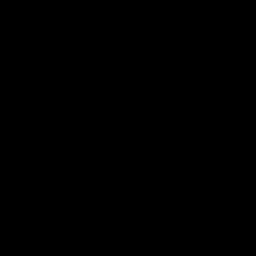

In [35]:
mask = dataset[40]["label"]
mask

In [ ]:
mask_b = dataset[50]["label"]

# Convert the image to a NumPy array
mask_array = np.array(mask_b)

# Get the unique pixel values
unique_values = np.unique(mask_array)

print("Unique pixel values:", unique_values)

    0         -- > 0
    21845     -- > 1
    43690     -- > 2
    65535     -- > 3

    1 for NCR
    2 for ED
    3 for ET
    0 for everything else.

### Binary Labels

In [ ]:
mask_array = np.array(mask)
image_array = np.array(image)

In [ ]:
# Create a new array for the masked image
masked_image_array = np.zeros_like(image_array)

# Apply the mask to the masked image array
masked_image_array[...] = np.where(mask_array > 0, mask_array, image_array[...])

# Create a new PIL image from the masked array
masked_image = PIL.Image.fromarray(masked_image_array)

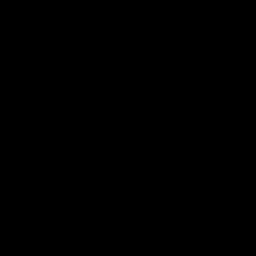

In [97]:
dataset[60]["label"]

In [ ]:
# Testing visual representation of input_boxees on the mri
#functions.show_boxes_on_image(dataset[50]["image"], [input_box])

### CUSTOM DATA LOADER

import torch
import torch.nn.functional as F

def pad_tensor(tensor, target_size):
    # Compute the padding for each dimension
    padding = []
    for i in range(tensor.dim()):
        pad = max(0, target_size[i] - tensor.size(i))
        padding.extend([0, pad])
    
    # Pad the tensor
    padded_tensor = F.pad(tensor, padding, 'constant', 0)
    
    return padded_tensor

In [53]:
def get_bounding_box(ground_truth_map,num):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map == num)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 5))
  x_max = min(W, x_max + np.random.randint(0, 5))
  y_min = max(0, y_min - np.random.randint(0, 5))
  y_max = min(H, y_max + np.random.randint(0, 5))
  bbox = [x_min, y_min, x_max, y_max]
  return bbox

In [34]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = functions.get_bounding_box(ground_truth_mask,1)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [35]:
# We're creating a processor using the pre-trained SAM model from Facebook.
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Now, we're setting up a training dataset using the SAMDataset class.
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# We're creating a DataLoader for the training dataset.
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# make sure we only compute gradients for mask decoder
# We're going through each named parameter in the model and checking its name.
# If the name starts with "vision_encoder" or "prompt_encoder", we set requires_grad to False.
# This prevents these parts of the model from being updated during training.

In [36]:
# We're creating a DataLoader for the training dataset.
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [64]:
# We're creating a model using the pre-trained "facebook/sam-vit-base" model.
model = SamModel.from_pretrained("facebook/sam-vit-base")
# make sure we only compute gradients for mask decoder
# We're going through each named parameter in the model and checking its name.
# If the name starts with "vision_encoder" or "prompt_encoder", we set requires_grad to False.
# This prevents these parts of the model from being updated during training.
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Train Model

In [65]:
# Note: Hyperparameter tuning could improve performance here
# We're defining an optimizer for the parameters of the mask decoder in the model.
# The Adam optimizer is being used with a learning rate of 1e-5 and weight decay of 0.
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# We're defining a segmentation loss function.
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('CUDA IS ENABLED :',torch.cuda.is_available())
model.to(device)

CUDA IS ENABLED : True


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
num_epochs = 3
model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
      
      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    
    # Save the model's state dictionary
    torch.save(model.state_dict(), f"C:\\Users\\bouhe\\Documents\\model_{epoch}.pth")

    # If you want to save additional information like optimizer state
    # and training history, you can create a dictionary
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,  # Example: current training epoch
    }
    torch.save(checkpoint, 'checkpoint_.pth')


## Inference

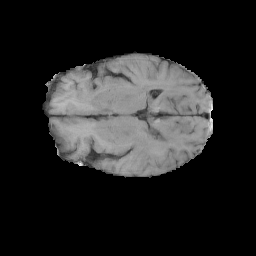

In [67]:
# let's take a random training example
idx = 20

# load image
image = dataset_test[idx]["image"]
image

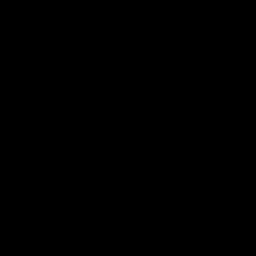

In [68]:
dataset_test[idx]["label"]

In [ ]:
t1n_filtered[idx]

('C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\BraTS-GLI-01174-000\\t1n\\Slice_dim2_70.png',
 'C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\BraTS-GLI-01174-000\\seg\\Slice_dim2_70.png')

In [50]:
image = dataset_test[idx]["image"]
mask = dataset_test[idx]["label"]
image_array = np.array(image)
mask_array = np.array(mask)

##### FUSION MODEL 

In [76]:
# load the model 0
model = SamModel.from_pretrained("facebook/sam-vit-base")
model.load_state_dict(torch.load(r"C:\Users\bouhe\Documents\TRAINED FUSION\model_0.pth"))
model.to("cuda")
# We're creating a processor using the pre-trained SAM model from Facebook.
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [72]:
# load the model 1
model = SamModel.from_pretrained("facebook/sam-vit-base")
model.load_state_dict(torch.load('C:\\Users\\bouhe\\Documents\\TRAINED FUSION\\model_1.pth'))
model.to("cuda")
# We're creating a processor using the pre-trained SAM model from Facebook.
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

##### NON FUSION MODEL

In [69]:
# load the model 0
model = SamModel.from_pretrained("facebook/sam-vit-base")
model.load_state_dict(torch.load(r"C:\Users\bouhe\Documents\TRAINED NORMAL\model_non_fusion_0.pth"))
model.to("cuda")
# We're creating a processor using the pre-trained SAM model from Facebook.
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [38]:
# All predictions :
predicted_masks_non_f_1 = []

for element in tqdm(dataset_test, desc="Processing images", unit="image"):
    
    mask_array = np.array(element['label'])
    image = element['image']
    
    # get box prompt based on ground truth segmentation map
    prompt = get_bounding_box(mask_array,1)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to('cuda')
    model.eval()

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    predicted_masks_non_f_1.append(medsam_seg)

Processing images: 100%|██████████| 24523/24523 [2:05:55<00:00,  3.25image/s]  


In [71]:
# load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")
model.load_state_dict(torch.load(r"C:\Users\bouhe\Documents\TRAINED NORMAL\model_non_fusion_1.pth"))
model.to("cuda")
# We're creating a processor using the pre-trained SAM model from Facebook.
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [40]:
# All predictions :
predicted_masks_non_f_2 = []

for element in tqdm(dataset_test, desc="Processing images", unit="image"):
    
    mask_array = np.array(element['label'])
    image = element['image']
    
    # get box prompt based on ground truth segmentation map
    prompt = get_bounding_box(mask_array,1)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to('cuda')
    model.eval()

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    predicted_masks_non_f_2.append(medsam_seg)

Processing images: 100%|██████████| 24523/24523 [2:03:04<00:00,  3.32image/s]  


##### Inference

In [70]:
# get box prompt based on ground truth segmentation map
prompt = get_bounding_box(mask_array,1)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to('cuda')
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)
  
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

#0 normal

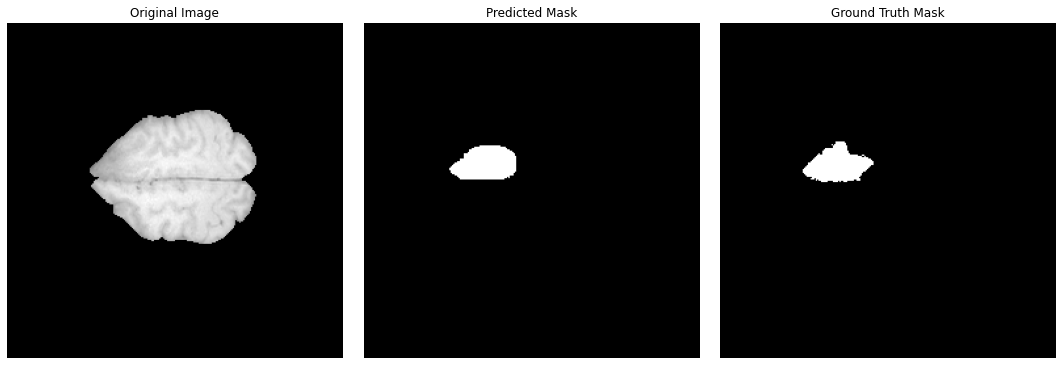

Dice Score : 0.8640076886112446
Jaccard Index : 0.760575296108291
SSIM : 0.9997354457648868
Specificity : 0.9975972344944116
Sensitivty : 0.875365141187926
raTS-GLI-01489-000\t1n\Slice_dim2_120.png


C:\Users\bouhe\AppData\Local\Temp\ipykernel_9400\2740733576.py:29: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  sim1 = compare_ssim(medsam_seg,mask_array)


In [66]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axes[0].imshow(np.array(image),cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display the predicted mask
axes[1].imshow(np.array(image))
axes[1].imshow(medsam_seg, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

# Display the ground truth mask
axes[2].imshow(np.array(image))
axes[2].imshow(mask_array, cmap="gray")
axes[2].set_title("Ground Truth Mask")
axes[2].axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

score_dice1 = dice(medsam_seg,mask_array)
jaccard1 = Jaccard(medsam_seg,mask_array)
sim1 = compare_ssim(medsam_seg,mask_array)
true_positives1, false_negatives1, true_negatives1, false_positives1 = confusion_matrix(medsam_seg,mask_array)
sensi1 = sens(true_positives1, false_negatives1)
speci1 = spec(true_negatives1, false_positives1)
    
print('Dice Score :' , score_dice1)
print('Jaccard Index :' , jaccard1)
print('SSIM :' , sim1)
print('Specificity :' , speci1)
print('Sensitivty :' , sensi1)

#File path
print(t1n_filtered[idx][0][-42:])

# Inference

In [121]:
idx = 100
t1n_filtered[idx]

('C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\BraTS-GLI-01175-000\\t1n\\Slice_dim2_95.png',
 'C:\\Users\\bouhe\\OneDrive\\Bureau\\pfe\\dataset\\png_format\\train\\BraTS-GLI-01175-000\\seg\\Slice_dim2_95.png')

In [122]:
image = dataset_test[idx]["image"]
mask = dataset_test[idx]["label"]
image_array = np.array(image)
mask_array = np.array(mask)

In [123]:
# load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

model.load_state_dict(torch.load(r"C:\Users\bouhe\Documents\TRAINED NORMAL\model_non_fusion_1.pth"))

model.to("cuda")
# We're creating a processor using the pre-trained SAM model from Facebook.
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [124]:
# get box prompt based on ground truth segmentation map
prompt = get_bounding_box(mask_array,1)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to('cuda')
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)
  
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

#epoch 1 normal

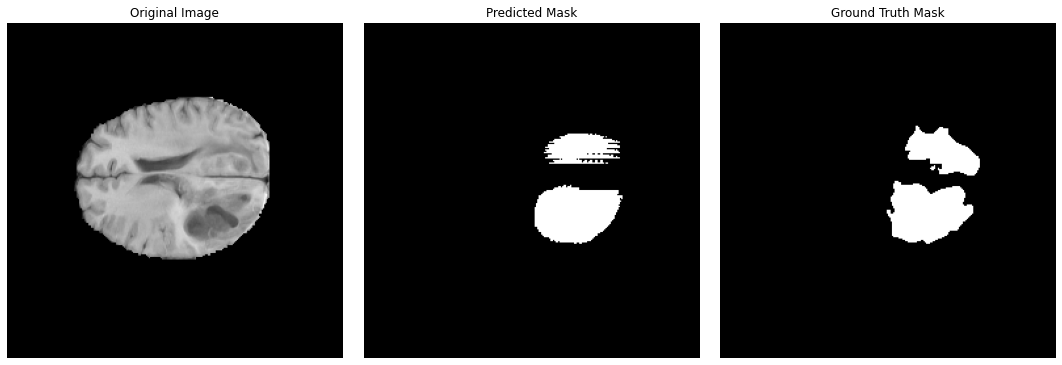

Dice Score : 0.8365098272781417
Jaccard Index : 0.7189659585359611
Specificity : 0.9930551079600387
Sensitivty : 0.8081127733026467
BraTS-GLI-01175-000\t1n\Slice_dim2_95.png


In [125]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axes[0].imshow(np.array(image),cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display the predicted mask
axes[1].imshow(np.array(image))
axes[1].imshow(medsam_seg, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

# Display the ground truth mask
axes[2].imshow(np.array(image))
axes[2].imshow(mask_array, cmap="gray")
axes[2].set_title("Ground Truth Mask")
axes[2].axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

score_dice1 = dice(medsam_seg,mask_array)
jaccard1 = Jaccard(medsam_seg,mask_array)
#sim1 = compare_ssim(medsam_seg,mask_array)
true_positives1, false_negatives1, true_negatives1, false_positives1 = confusion_matrix(medsam_seg,mask_array)
sensi1 = sens(true_positives1, false_negatives1)
speci1 = spec(true_negatives1, false_positives1)
    
print('Dice Score :' , score_dice1)
print('Jaccard Index :' , jaccard1)
#print('SSIM :' , sim1)
print('Specificity :' , speci1)
print('Sensitivty :' , sensi1)

#File path
print(t1n_filtered[idx][0][-41:])

#0

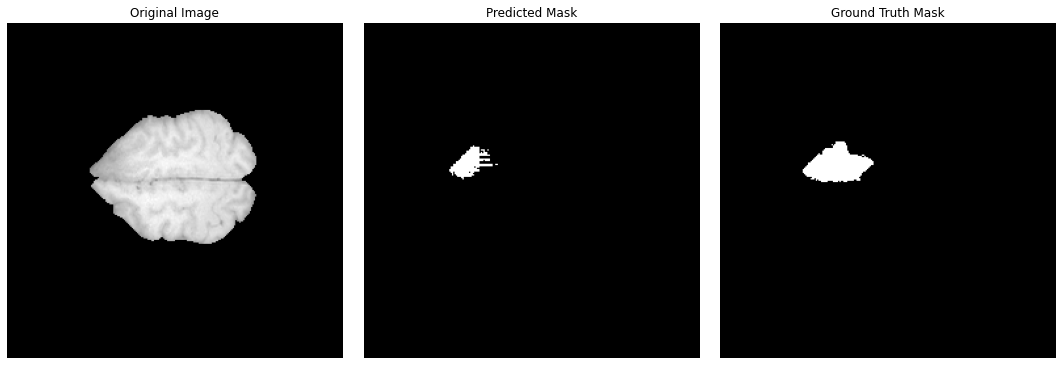

Dice Score : 0.5598885793871866
Jaccard Index : 0.38878143133462284
SSIM : 0.9990284637685053
Specificity : 0.9998914880094251
Sensitivty : 0.3914313534566699
raTS-GLI-01489-000\t1n\Slice_dim2_120.png


C:\Users\bouhe\AppData\Local\Temp\ipykernel_22348\2740733576.py:29: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  sim1 = compare_ssim(medsam_seg,mask_array)


In [71]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axes[0].imshow(np.array(image),cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display the predicted mask
axes[1].imshow(np.array(image))
axes[1].imshow(medsam_seg, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

# Display the ground truth mask
axes[2].imshow(np.array(image))
axes[2].imshow(mask_array, cmap="gray")
axes[2].set_title("Ground Truth Mask")
axes[2].axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

score_dice1 = dice(medsam_seg,mask_array)
jaccard1 = Jaccard(medsam_seg,mask_array)
sim1 = compare_ssim(medsam_seg,mask_array)
true_positives1, false_negatives1, true_negatives1, false_positives1 = confusion_matrix(medsam_seg,mask_array)
sensi1 = sens(true_positives1, false_negatives1)
speci1 = spec(true_negatives1, false_positives1)
    
print('Dice Score :' , score_dice1)
print('Jaccard Index :' , jaccard1)
print('SSIM :' , sim1)
print('Specificity :' , speci1)
print('Sensitivty :' , sensi1)

#File path
print(t1n_filtered[idx][0][-41:])

#1 

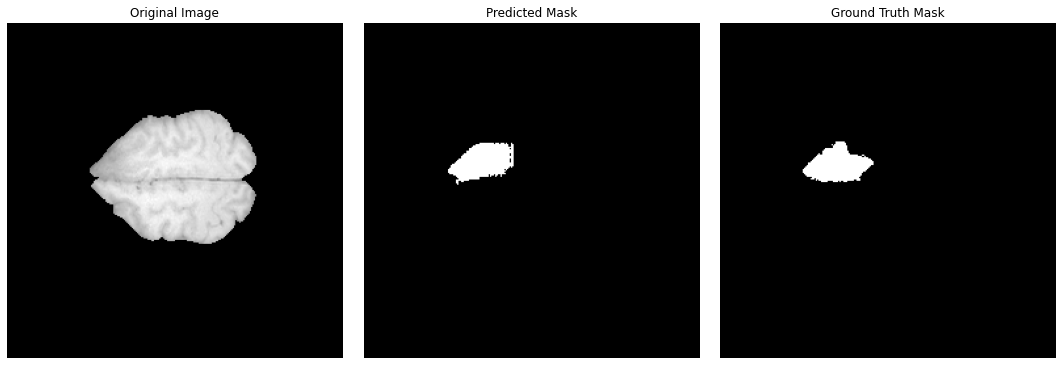

Dice Score : 0.8415458937198068
Jaccard Index : 0.7264386989157632
SSIM : 0.9996470460206464
Specificity : 0.9973337053744439
Sensitivty : 0.8481012658227848
raTS-GLI-01489-000\t1n\Slice_dim2_120.png


C:\Users\bouhe\AppData\Local\Temp\ipykernel_22348\2740733576.py:29: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  sim1 = compare_ssim(medsam_seg,mask_array)


In [74]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
axes[0].imshow(np.array(image),cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display the predicted mask
axes[1].imshow(np.array(image))
axes[1].imshow(medsam_seg, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

# Display the ground truth mask
axes[2].imshow(np.array(image))
axes[2].imshow(mask_array, cmap="gray")
axes[2].set_title("Ground Truth Mask")
axes[2].axis("off")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

score_dice1 = dice(medsam_seg,mask_array)
jaccard1 = Jaccard(medsam_seg,mask_array)
sim1 = compare_ssim(medsam_seg,mask_array)
true_positives1, false_negatives1, true_negatives1, false_positives1 = confusion_matrix(medsam_seg,mask_array)
sensi1 = sens(true_positives1, false_negatives1)
speci1 = spec(true_negatives1, false_positives1)
    
print('Dice Score :' , score_dice1)
print('Jaccard Index :' , jaccard1)
print('SSIM :' , sim1)
print('Specificity :' , speci1)
print('Sensitivty :' , sensi1)

#File path
print(t1n_filtered[idx][0][-41:])

In [75]:
from tqdm import tqdm

In [77]:
# All predictions :
predicted_masks = []

for element in tqdm(dataset_test, desc="Processing images", unit="image"):
    
    mask_array = np.array(element['label'])
    image = element['image']
    
    # get box prompt based on ground truth segmentation map
    prompt = get_bounding_box(mask_array,1)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to('cuda')
    model.eval()

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    predicted_masks.append(medsam_seg)

Processing images: 100%|██████████| 24523/24523 [2:19:40<00:00,  2.93image/s]  


In [188]:
chime.success()


In [81]:
t1n_pred_path = [t1n_filtered[i][0].replace('train','predicted_normal') for i in range(len(t1n_filtered))]

In [ ]:
# Loop through the list and save each array as an image
for image_array,path in tqdm(zip(predicted_masks, t1n_pred_path), desc="Saving images"):
    # Convert the array to a numpy array with uint8 data type
    image_array = np.array(image_array, dtype=np.uint8)
    
    # Create an image from the array
    image = PIL.Image.fromarray(image_array, mode="L")  # "L" mode for grayscale
    
    # Save the image with the corresponding name
    print(path,image_array)
    image.save(path)

### Performance Evaluation

#### Dice score

In [58]:
# Mean DICE Score
def dice(medsam_seg,mask_array):
    # Convert images to numpy arrays
    predicted_mask_np = medsam_seg

    # Compute the intersection and sums of pixels
    intersection = np.sum(np.logical_and(predicted_mask_np, mask_array))
    sum_predicted = np.sum(predicted_mask_np)
    sum_ground_truth = np.sum(mask_array)

    # Compute the Dice score
    dice_score = 2 * intersection / (sum_predicted + sum_ground_truth)
    
    return(dice_score)


#### Jaccard index

In [59]:
def Jaccard(predicted_mask_np,mask_array):
    # Compute the intersection and union of pixels
    intersection = np.sum(np.logical_and(predicted_mask_np,mask_array))
    union = np.sum(np.logical_or(predicted_mask_np,mask_array))

    # Compute the Jaccard Index
    jaccard_index = intersection / union
    return(jaccard_index)
#print("Jaccard Index:", jaccard_index)

#### SSIM

In [60]:
from skimage.metrics import structural_similarity as compare_ssim
def ssim(predicted_mask_np ,mask_array):
    

    # Compute the SSIM
    ssim_score = compare_ssim(predicted_mask_np ,mask_array)
    return(ssim)

#print("SSIM Score:", ssim_score)

####  Confusion matrix

In [61]:
def confusion_matrix(predicted_mask_np, mask_array):
    # Calculate True Positives and False Negatives
    true_positives = np.sum(np.logical_and(predicted_mask_np, mask_array))
    false_negatives = np.sum(np.logical_and(np.logical_not(predicted_mask_np), mask_array))
    # Calculate True Negatives and False Positives
    true_negatives = np.sum(np.logical_and(np.logical_not(predicted_mask_np), np.logical_not(mask_array)))
    false_positives = np.sum(np.logical_and(predicted_mask_np, np.logical_not(mask_array)))
    return(true_positives, false_negatives, true_negatives, false_positives)


#### Sensitivty

In [62]:
def sens(true_positives, false_negatives):
    # Calculate Sensitivity (True Positive Rate)
    sensitivity = true_positives / (true_positives + false_negatives)
    return(sensitivity)

#print("Sensitivity (TPR):", sensitivity)

#### Specificity

In [63]:
def spec(true_negatives, false_positives):
    # Calculate Specificity (True Negative Rate)
    specificity = true_negatives / (true_negatives + false_positives)
    return(specificity)

#print("Specificity (TNR):", specificity)

In [64]:
score_dice,jaccard,sim,speci,sensi = [],[],[],[],[]

In [ ]:
for pred,gt in zip(predicted_masks_non_f_1,t1n_filtered):
    
    # Open an image
    image = PIL.Image.open(gt[1]) 

    # Convert the image to a NumPy array
    mask_array = np.array(image)
    
    score_dice.append(dice(pred,mask_array))
    jaccard.append(Jaccard(pred,mask_array))
    sim.append(compare_ssim(pred ,mask_array))
    true_positives, false_negatives, true_negatives, false_positives = confusion_matrix(pred,mask_array)
    speci.append(spec(true_negatives, false_positives))
    sensi.append(sens(true_positives, false_negatives))
    
print('Dice Score :' ,np.mean(score_dice))
print('Jaccard Index :' ,np.mean(jaccard))
print('SSIM :' ,np.mean(sim))
print('Specificity :' ,np.mean(speci))
print('Sensitivty :' ,np.mean(sensi))

In [50]:
for pred,gt in zip(predicted_masks_non_f_2,t1n_filtered):
    
    # Open an image
    image = PIL.Image.open(gt[1]) 

    # Convert the image to a NumPy array
    mask_array = np.array(image)
    
    score_dice.append(dice(pred,mask_array))
    jaccard.append(Jaccard(pred,mask_array))
    sim.append(compare_ssim(pred ,mask_array))
    true_positives, false_negatives, true_negatives, false_positives = confusion_matrix(pred,mask_array)
    speci.append(spec(true_negatives, false_positives))
    sensi.append(sens(true_positives, false_negatives))
    
print('Dice Score :' ,np.mean(score_dice))
print('Jaccard Index :' ,np.mean(jaccard))
print('SSIM :' ,np.mean(sim))
print('Specificity :' ,np.mean(speci))
print('Sensitivty :' ,np.mean(sensi))

C:\Users\bouhe\AppData\Local\Temp\ipykernel_7872\3652228023.py:11: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  sim.append(compare_ssim(pred ,mask_array))


Dice Score : 0.7410537189881816
Jaccard Index : 0.6179527896067623
SSIM : 0.9991963914486591
Specificity : 0.9932784414947607
Sensitivty : 0.841689810083357


In [78]:
for pred,gt in zip(predicted_masks,t1n_filtered):
    
    # Open an image
    image = PIL.Image.open(gt[1]) 

    # Convert the image to a NumPy array
    mask_array = np.array(image)
    
    score_dice.append(dice(pred,mask_array))
    jaccard.append(Jaccard(pred,mask_array))
    sim.append(compare_ssim(pred ,mask_array))
    true_positives, false_negatives, true_negatives, false_positives = confusion_matrix(pred,mask_array)
    speci.append(spec(true_negatives, false_positives))
    sensi.append(sens(true_positives, false_negatives))
    
print('Dice Score :' ,np.mean(score_dice))
print('Jaccard Index :' ,np.mean(jaccard))
print('SSIM :' ,np.mean(sim))
print('Specificity :' ,np.mean(speci))
print('Sensitivty :' ,np.mean(sensi))

C:\Users\bouhe\AppData\Local\Temp\ipykernel_22348\1586440660.py:11: UserWarning: Inputs have mismatched dtypes. Setting data_range based on im1.dtype.
  sim.append(compare_ssim(pred ,mask_array))


Dice Score : 0.5599570807043689
Jaccard Index : 0.42990439357838267
SSIM : 0.9987996599015008
Specificity : 0.9953492231057433
Sensitivty : 0.5376540332077726


#0
- Dice Score : 0.5599570807043689
- Jaccard Index : 0.42990439357838267
- SSIM : 0.9987996599015008
- Specificity : 0.9953492231057433
- Sensitivty : 0.5376540332077726

#1
- Dice Score : 0.710560475938147
- Jaccard Index : 0.5813044060910975
- SSIM : 0.9990325528534505
- Sensitivty : 0.9922630519084908
- Specificity : 0.7947214326090183

In [ ]:
chime.succes()

#### Summarized results

In [201]:
print('Dice Score :' ,np.mean(score_dice))
print('Jaccard Index :' ,np.mean(jaccard))
print('SSIM :' ,np.mean(sim))
print('Sensitivty :' ,np.mean(sensi))
print('Specificity :' ,np.mean(speci))

Dice Score : 0.710560475938147
Jaccard Index : 0.5813044060910975
SSIM : 0.9990325528534505
Sensitivty : 0.9922630519084908
Specificity : 0.7947214326090183
